In [ ]:
from google.colab import files

files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 98% 374M/380M [00:06<00:00, 63.2MB/s]
100% 380M/380M [00:06<00:00, 65.2MB/s]


In [4]:
import zipfile
zipref = zipfile.ZipFile('/content/augmented-alzheimer-mri-dataset.zip', mode = 'r')
zipref.extractall('data')
zipref.close()

In [5]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow

In [6]:
train_count = test_count = 0
for dirpath, dirnames, filenames in os.walk('/content/data'):
  if len(filenames)>0:
    dir = os.path.basename(os.path.dirname(dirpath))
    if train_count == 0 and dir == 'AugmentedAlzheimerDataset':
      print(dir.capitalize() + ':')
      train_count +=1
    elif test_count == 0 and dir == 'OriginalDataset':
      print('\n' + dir.capitalize() + ':')
      test_count +=1
    print(f'There are {len(filenames)} files in {os.path.basename(dirpath)}' )


Originaldataset:
There are 2240 files in VeryMildDemented
There are 3200 files in NonDemented
There are 64 files in ModerateDemented
There are 896 files in MildDemented
Augmentedalzheimerdataset:
There are 8960 files in VeryMildDemented
There are 9600 files in NonDemented
There are 6464 files in ModerateDemented
There are 8960 files in MildDemented


In [7]:
train_dir = '/content/data/AugmentedAlzheimerDataset'
test_dir = '/content/data/OriginalDataset'

In [8]:
def plot_images_with_labels(dir = train_dir):
  label_list = []
  img_list = []
  for dirpath, dirnames, filenames in os.walk(dir):
    if len(filenames) > 0:
      label_list.append(os.path.basename(dirpath))
      random_num = random.randint(0, len(filenames)-1)
      files = [i for i in os.listdir(dirpath)]
      img = cv2.imread(os.path.join(dirpath, files[random_num]))
      img_list.append(img)
      directory = dirpath
  fig, ax = plt.subplots(int(len(label_list)/2), 2, figsize = (6.5, 10))
  fig.set_facecolor('black')
  for i, label in enumerate(label_list):
    ax[i // 2, i % 2].imshow(img_list[i])
    ax[i // 2, i % 2].set_xlabel(label, color = 'white')
  fig.suptitle(os.path.basename(os.path.dirname(directory)), fontsize = 16, color = 'white')
  plt.tight_layout()

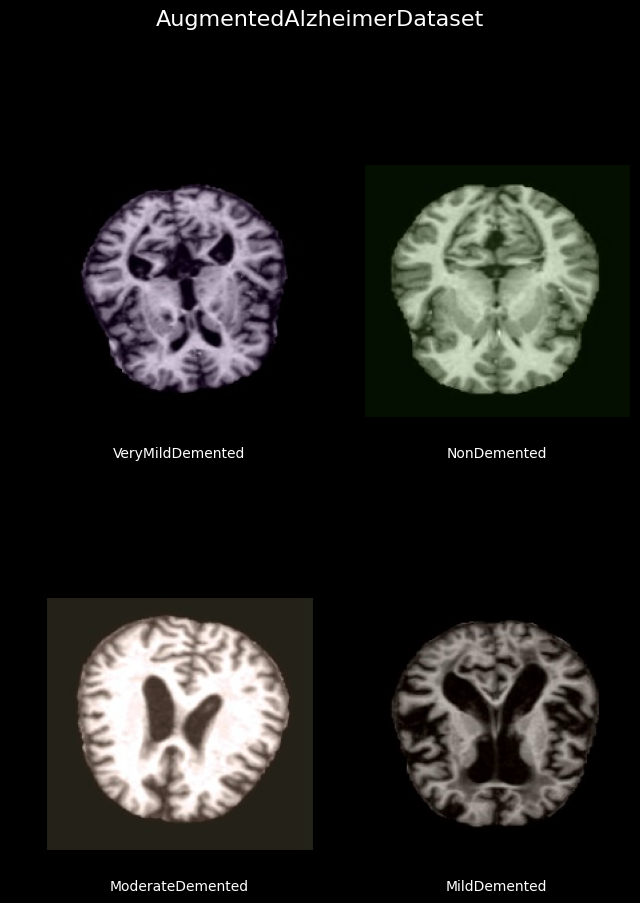

In [9]:
plot_images_with_labels(train_dir)

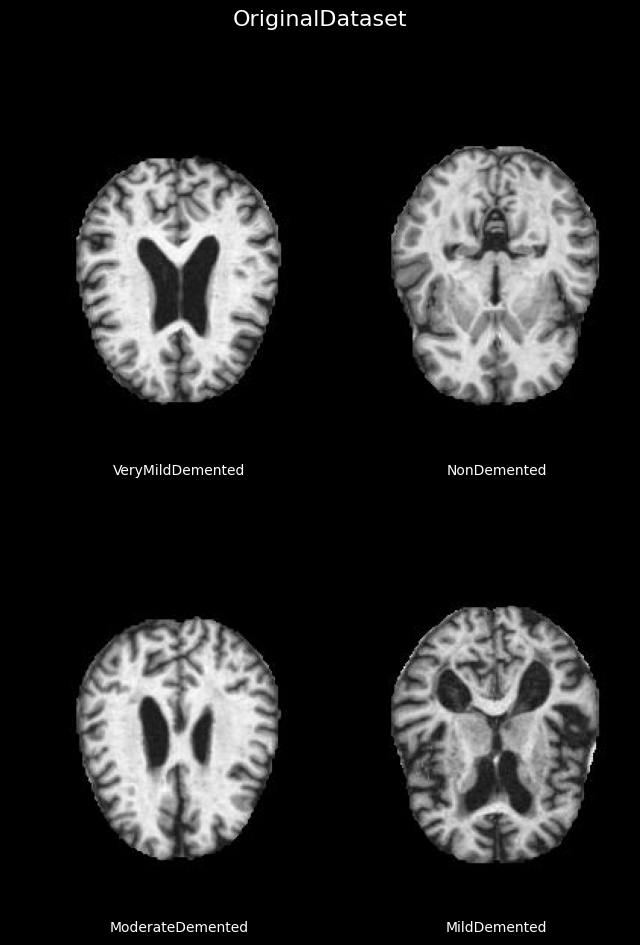

In [10]:
plot_images_with_labels(test_dir)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                   validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               class_mode = 'categorical',
                                               shuffle = True,
                                               batch_size = 32,
                                               target_size = (228, 228),
                                               subset = 'training')

valid_data = train_datagen.flow_from_directory(train_dir,
                                               class_mode = 'categorical',
                                               shuffle = True,
                                               batch_size = 32,
                                               target_size = (228, 228),
                                               subset = 'validation')

test_data = test_datagen.flow_from_directory(test_dir,
                                             class_mode = 'categorical',
                                             shuffle = True,
                                             batch_size = 32,
                                             target_size = (228, 228))

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [12]:
from tensorflow.random import set_seed as SEED
from tensorflow.keras import Sequential as SQ
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy as CCE
from tensorflow.keras.optimizers import Adam

In [13]:
SEED(28)

model = SQ()
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 input_shape = (228, 228, 3),
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32,
                 kernel_size = 3,
                 strides = 1,
                 padding = 'valid',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = 1))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))

In [14]:
model.compile(loss = CCE(),
              optimizer = Adam(),
              metrics = ['accuracy'])

In [15]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes = np.unique(train_data.classes), y = train_data.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [16]:
history = model.fit(train_data, epochs = 12, validation_data = valid_data, class_weight = class_weights)

Epoch 1/12
850/850 [==============================] - 539s 619ms/step - loss: 1.3663 - accuracy: 0.3909 - val_loss: 0.9920 - val_accuracy: 0.5443
Epoch 2/12
850/850 [==============================] - 520s 611ms/step - loss: 0.9466 - accuracy: 0.5285 - val_loss: 0.7831 - val_accuracy: 0.6461
Epoch 3/12
850/850 [==============================] - 520s 612ms/step - loss: 0.8109 - accuracy: 0.6044 - val_loss: 0.6917 - val_accuracy: 0.6978
Epoch 4/12
850/850 [==============================] - 520s 611ms/step - loss: 0.6710 - accuracy: 0.6792 - val_loss: 0.6125 - val_accuracy: 0.7468
Epoch 5/12
850/850 [==============================] - 529s 623ms/step - loss: 0.5584 - accuracy: 0.7353 - val_loss: 0.5206 - val_accuracy: 0.7690
Epoch 6/12
850/850 [==============================] - 520s 612ms/step - loss: 0.4875 - accuracy: 0.7729 - val_loss: 0.4845 - val_accuracy: 0.7878
Epoch 7/12
850/850 [==============================] - 521s 613ms/step - loss: 0.4291 - accuracy: 0.7971 - val_loss: 0.4491 -

In [17]:
model.evaluate(test_data)

200/200 [==============================] - 14s 67ms/step - loss: 0.0839 - accuracy: 0.9714


[0.08389880508184433, 0.9714062213897705]

In [21]:
model.save('Aug_MRI_model.keras')

In [47]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [48]:
!cp /content/Aug_MRI_model.keras /content/drive/MyDrive/Colab_Files/Aug_MRI_model.keras

In [143]:
def plot_predictions(dir = test_dir, n = 5):
  random_filenums = []
  for i in range(n):
    labels = [i for i in os.listdir(test_dir)]
    random_lab = random.randint(0, len(labels)-1)
    file_dir = os.path.join(test_dir, labels[random_lab])
    files = [i for i in os.listdir(file_dir)]
    val = True
    while val == True:
      random_filenum = random.randint(0, len(files)-1)
      if random_filenum not in random_filenums:
        random_filenums.append(random_filenum)
        val = False
      else:
        val =  True
    random_img = cv2.imread(os.path.join(file_dir, files[random_filenum]))
    img_array = np.array(random_img)/255.
    resized_img = cv2.resize(img_array, (228, 228))
    reshaped_array = resized_img.reshape(1, 228, 228, 3)
    prediction = model.predict(reshaped_array)
    prediction = prediction.flatten()
    pred_label = labels[np.argmin(prediction)]
    cv2_imshow(resized_orig_img)

1/1 [==============================] - 0s 19ms/step
ModerateDemented
ModerateDemented


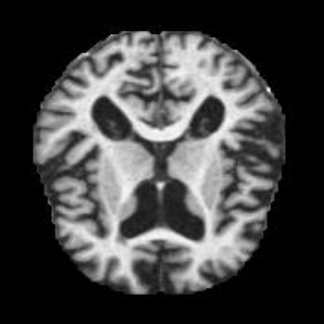

1/1 [==============================] - 0s 18ms/step
NonDemented
NonDemented


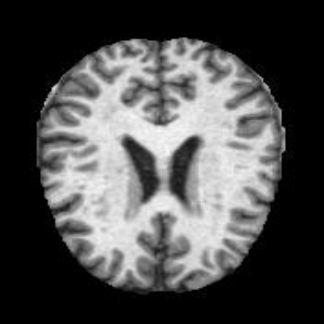

1/1 [==============================] - 0s 27ms/step
ModerateDemented
ModerateDemented


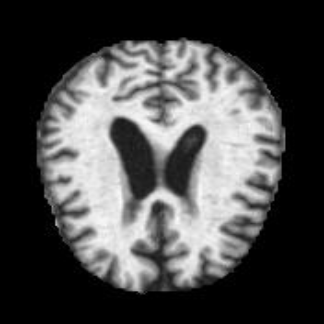

1/1 [==============================] - 0s 32ms/step
NonDemented
MildDemented


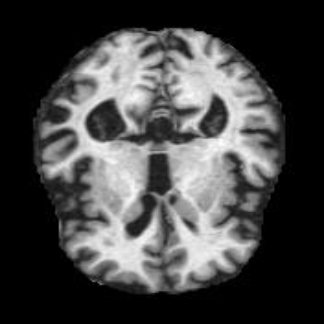

1/1 [==============================] - 0s 29ms/step
NonDemented
NonDemented


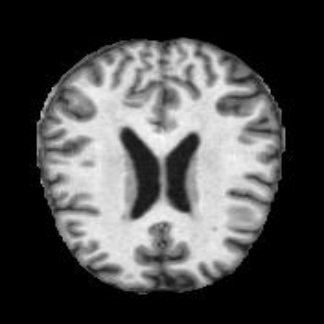

In [144]:
plot_predictions()